In [1]:
%run ./model_end_events_for_outages_METHODS.ipynb

In [2]:
from importlib import reload
#reload(Utilities)
#reload(clm)
# NOTE: To reload a class imported as, e.g., 
# from module import class
# One must call:
#   1. import module
#   2. reload module
#   3. from module import class

import sys, os
import re
import string

from pathlib import Path
import json
import pickle

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype, is_datetime64_dtype, is_timedelta64_dtype
from scipy import stats
import datetime
import time
from natsort import natsorted, ns, natsort_keygen
from packaging import version
import copy
from functools import reduce

import itertools

import pyodbc
#---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.colors as mcolors
import matplotlib.cm as cm #e.g. for cmap=cm.jet
#---------------------------------------------------------------------
sys.path.insert(0, os.path.realpath('..'))
import Utilities_config
#-----
import CommonLearningMethods as clm
#-----
from MeterPremise import MeterPremise
from EEMSP import EEMSP
#-----
from AMI_SQL import AMI_SQL
from AMINonVee_SQL import AMINonVee_SQL
from AMIEndEvents_SQL import AMIEndEvents_SQL
from AMIUsgInst_SQL import AMIUsgInst_SQL
from DOVSOutages_SQL import DOVSOutages_SQL
#-----
from GenAn import GenAn
from AMINonVee import AMINonVee
from AMIEndEvents import AMIEndEvents
from AMIEDE_DEV import AMIEDE_DEV
from MECPODf import MECPODf
from MECPOAn import MECPOAn
from MECPOCollection import MECPOCollection
from AMIUsgInst import AMIUsgInst
from DOVSOutages import DOVSOutages
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_sql_aids_dir())
import Utilities_sql
import TableInfos
from TableInfos import TableInfo
from SQLElement import SQLElement
from SQLElementsCollection import SQLElementsCollection
from SQLSelect import SQLSelectElement, SQLSelect
from SQLFrom import SQLFrom
from SQLWhere import SQLWhereElement, SQLWhere
from SQLJoin import SQLJoin, SQLJoinCollection
from SQLGroupBy import SQLGroupByElement, SQLGroupBy
from SQLHaving import SQLHaving
from SQLOrderBy import SQLOrderByElement, SQLOrderBy
from SQLQuery import SQLQuery
from SQLQueryGeneric import SQLQueryGeneric
#---------------------------------------------------------------------
#sys.path.insert(0, os.path.join(os.path.realpath('..'), 'Utilities'))
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
from Utilities_df import DFConstructType
import Utilities_dt
import Plot_General
import Plot_Box_sns
import Plot_Hist
import Plot_Bar
import GrubbsTest
import DataFrameSubsetSlicer
from DataFrameSubsetSlicer import DataFrameSubsetSlicer as DFSlicer
from CustomJSON import CustomEncoder, CustomWriter

In [3]:
from sklearn.preprocessing import OrdinalEncoder

In [4]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

import scipy

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------------------------------------------------

In [5]:
fig_num=0

# save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models_00_05'
save_dir_model_base = r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230615\Models'

In [6]:
save_results = True
# save_dir_model = None
save_dir_model = 'Subgroups_EEMSP_exclude'
if save_dir_model is None:
    save_dir_model = f"Subgroups_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
save_dir_model = os.path.join(save_dir_model_base, save_dir_model)
#-----
if not os.path.exists(save_dir_model) and save_results:
    os.makedirs(save_dir_model)

In [7]:
combine_others=True

merged_df_full=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_full.pkl'))
merged_df_no_outg=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg.pkl'))
merged_df_no_outg_prstn=pd.read_pickle(os.path.join(save_dir_model_base, 'merged_df_no_outg_prstn.pkl'))
#-------------------------
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_full.pkl'), 'rb') as handle:
#     mecpo_coll_full = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg.pkl'), 'rb') as handle:
#     mecpo_coll_no_outg = pickle.load(handle)
# with open(os.path.join(save_dir_model_base, 'mecpo_coll_no_outg_prstn.pkl'), 'rb') as handle:
#     mecpo_coll_no_outg_prstn = pickle.load(handle)
#-------------------------
with open(os.path.join(save_dir_model_base, 'counts_series_full.pkl'), 'rb') as handle:
    counts_series_full = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_no_outg.pkl'), 'rb') as handle:
    counts_series_no_outg = pickle.load(handle)
with open(os.path.join(save_dir_model_base, 'counts_series_no_outg_prstn.pkl'), 'rb') as handle:
    counts_series_no_outg_prstn = pickle.load(handle)
    
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
merged_df_no_outg_prstn.index.names     = ['trsf_pole_nb', 'no_outg_rec_nb']
counts_series_no_outg_prstn.index.names = ['trsf_pole_nb', 'no_outg_rec_nb']

In [8]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 180)
(599500, 180)
(178946, 180)


### Initiate summary_dict

In [9]:
summary_dict = dict()
#-------------------------
an_keys = natsorted(merged_df_full.columns.get_level_values(0).unique().tolist())
assert(an_keys==natsorted(merged_df_no_outg.columns.get_level_values(0).unique().tolist()))
assert(an_keys==natsorted(merged_df_no_outg_prstn.columns.get_level_values(0).unique().tolist()))
#-----
summary_dict['an_keys'] = an_keys
#-------------------------
# n_top_reasons_to_inclue = 10
n_top_reasons_to_inclue = None
#-----
summary_dict['n_top_reasons_to_inclue'] = n_top_reasons_to_inclue

# !!!!!!! No outage data have indices backwards from outages!!!!!


In [10]:
merged_df_no_outg = merged_df_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg = counts_series_no_outg.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()
#-----
merged_df_no_outg_prstn = merged_df_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
counts_series_no_outg_prstn = counts_series_no_outg_prstn.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb']).squeeze()

In [11]:
merged_df_full.columns.get_level_values(1).unique().tolist()

['Access Point has lost connectivity with FHSS 900 MHz band',
 'Demand Reset',
 'Detected end of voltage sag',
 'Detected end of voltage swell',
 'Device Failed',
 'Device exceeded the max allowable trap threshold',
 'Diag1: Polarity, Cross Phase, Reverse Energy Flow: Angle out of tolerance',
 'Error occurred when attempting to synch meter time with NIC time for device',
 'Ignoring Read: time in the future',
 'Last Gasp',
 'Low Battery',
 'Measurement Error (C1219 Table 3)',
 'Meter Program Seal mismatch for Device',
 'Meter detected a high temperature condition (C1219 Table 3)',
 'Meter detected loss of time (C1219 Table 3)',
 'Meter needs explicit time sync',
 'N/A failed consecutively for 1 or more times',
 'NET_MGMT command failed consecutively',
 'NET_MGMT command has insufficient privileges',
 'NIC Link Layer Handshake Failed',
 'NIC Power Restore Trap Received from device',
 'NVRAM Error',
 'Over Voltage',
 'Primary Power Down',
 'Primary Power Up',
 'Requested operation could n

In [12]:
if Path(save_dir_model_base).name=='Models' or Path(save_dir_model_base).name=='Models_00_05':
    is_norm=True
elif Path(save_dir_model_base).name=='Models_raw' or Path(save_dir_model_base).name=='Models_00_05_raw':
    is_norm=False
else:
    assert(0)

if n_top_reasons_to_inclue is not None:
    merged_df_full, [merged_df_no_outg, merged_df_no_outg_prstn] = MECPOCollection.get_top_reasons_subset_from_merged_cpo_df_and_project_from_others(
        merged_cpo_df=merged_df_full,
        other_dfs_w_counts_series=[ 
            [merged_df_no_outg, counts_series_no_outg], 
            [merged_df_no_outg_prstn, counts_series_no_outg_prstn]
        ], 
        how='per_mecpo_an', 
        n_reasons_to_include=n_top_reasons_to_inclue,
        combine_others=combine_others,
        output_combine_others_col='Other Reasons',
        SNs_tags=None, 
        is_norm=is_norm, 
        counts_series=counts_series_full
    )

In [13]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 180)
(599500, 180)
(178946, 180)


In [14]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 180)
(599500, 180)
(178946, 180)


In [15]:
merged_df_full=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_full)
merged_df_no_outg=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg)
merged_df_no_outg_prstn=MECPOCollection.get_total_event_counts_for_merged_cpo_df(merged_df_no_outg_prstn)

In [16]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 186)
(599500, 186)
(178946, 186)


In [17]:
assert(len(set(merged_df_full.index).difference(set(counts_series_full.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(counts_series_no_outg.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(counts_series_no_outg_prstn.index)))==0)

merged_df_full = pd.merge(
    merged_df_full, 
    counts_series_full.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg = pd.merge(
    merged_df_no_outg, 
    counts_series_no_outg.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

merged_df_no_outg_prstn = pd.merge(
    merged_df_no_outg_prstn, 
    counts_series_no_outg_prstn.to_frame(name=('nSNs', 'nSNs')), 
    left_index=True, right_index=True, how='inner')

In [18]:
print(merged_df_full.shape)
print(merged_df_no_outg.shape)
print(merged_df_no_outg_prstn.shape)

(290457, 187)
(599500, 187)
(178946, 187)


In [19]:
merged_df_full

01-06 Days  \
                           Access Point has lost connectivity with FHSS 900 MHz band   
outg_rec_nb trsf_pole_nb                                                               
12580837    1863938736669                                                 0.0          
12580900    40830909D30090                                                0.0          
            40830909D30095                                                0.0          
            40830909D30135                                                0.0          
12580986    39830880B40002                                                0.0          
...                                                                       ...          
13149341    1864316751935                                                 0.0          
            1864477751803                                                 0.0          
            1864504751367                                                 0.0          
            1864635751610                                                 0.0          
13149360    41810795C40091                                                0.0          

                                                                     \
                           Demand Reset Detected end of voltage sag   
outg_rec_nb trsf_pole_nb                                              
12580837    1863938736669           0.0                         0.0   
12580900    40830909D30090          0.0                         0.0   
            40830909D30095          0.0                         0.0   
            40830909D30135          0.0                         0.0   
12580986    39830880B40002          0.0                         0.0   
...                                 ...                         ...   
13149341    1864316751935           0.0                         0.0   
            1864477751803           0.0                         0.0   
            1864504751367           0.0                         0.0   
            1864635751610           0.0                         0.0   
13149360    41810795C40091          0.0                         0.0   

                                                                        \
                           Detected end of voltage swell Device Failed   
outg_rec_nb trsf_pole_nb                                                 
12580837    1863938736669                            0.0           0.0   
12580900    40830909D30090                           0.0           0.0   
            40830909D30095                           0.0           0.0   
            40830909D30135                           0.0           0.0   
12580986    39830880B40002                           0.0           0.0   
...                                                  ...           ...   
13149341    1864316751935                            0.0           0.0   
            1864477751803                            0.0           0.0   
            1864504751367                            0.0           0.0   
            1864635751610                            0.0           0.0   
13149360    41810795C40091                           0.0           0.0   

                                                                             \
                           Device exceeded the max allowable trap threshold   
outg_rec_nb trsf_pole_nb                                                      
12580837    1863938736669                                               0.0   
12580900    40830909D30090                                              0.0   
            40830909D30095                                              0.0   
            40830909D30135                                              0.0   
12580986    39830880B40002                                              0.0   
...                                                                     ...   
13149341    1864316751935                                               0.0   
            1864477

In [20]:
print(merged_df_full.shape)
print(merged_df_full.index.get_level_values(0).nunique())
print(merged_df_full.index.get_level_values(1).nunique())

(290457, 187)
20714
129413


In [21]:
merged_df_full.index.get_level_values(1).value_counts()

trsf_pole_nb
PRIMARY           647
1862239702590      15
1862842702879      14
1861865702921      14
1861989702601      14
                 ... 
1836481710045       1
1836489709907       1
1836502709661       1
1836506709618       1
41810794D10153      1
Name: count, Length: 129413, dtype: int64

In [22]:
# merged_df_full['01-05 Days']
# merged_df_full['00-01 Days']

In [23]:
merged_df_full

01-06 Days  \
                           Access Point has lost connectivity with FHSS 900 MHz band   
outg_rec_nb trsf_pole_nb                                                               
12580837    1863938736669                                                 0.0          
12580900    40830909D30090                                                0.0          
            40830909D30095                                                0.0          
            40830909D30135                                                0.0          
12580986    39830880B40002                                                0.0          
...                                                                       ...          
13149341    1864316751935                                                 0.0          
            1864477751803                                                 0.0          
            1864504751367                                                 0.0          
            1864635751610                                                 0.0          
13149360    41810795C40091                                                0.0          

                                                                     \
                           Demand Reset Detected end of voltage sag   
outg_rec_nb trsf_pole_nb                                              
12580837    1863938736669           0.0                         0.0   
12580900    40830909D30090          0.0                         0.0   
            40830909D30095          0.0                         0.0   
            40830909D30135          0.0                         0.0   
12580986    39830880B40002          0.0                         0.0   
...                                 ...                         ...   
13149341    1864316751935           0.0                         0.0   
            1864477751803           0.0                         0.0   
            1864504751367           0.0                         0.0   
            1864635751610           0.0                         0.0   
13149360    41810795C40091          0.0                         0.0   

                                                                        \
                           Detected end of voltage swell Device Failed   
outg_rec_nb trsf_pole_nb                                                 
12580837    1863938736669                            0.0           0.0   
12580900    40830909D30090                           0.0           0.0   
            40830909D30095                           0.0           0.0   
            40830909D30135                           0.0           0.0   
12580986    39830880B40002                           0.0           0.0   
...                                                  ...           ...   
13149341    1864316751935                            0.0           0.0   
            1864477751803                            0.0           0.0   
            1864504751367                            0.0           0.0   
            1864635751610                            0.0           0.0   
13149360    41810795C40091                           0.0           0.0   

                                                                             \
                           Device exceeded the max allowable trap threshold   
outg_rec_nb trsf_pole_nb                                                      
12580837    1863938736669                                               0.0   
12580900    40830909D30090                                              0.0   
            40830909D30095                                              0.0   
            40830909D30135                                              0.0   
12580986    39830880B40002                                              0.0   
...                                                                     ...   
13149341    1864316751935                                               0.0   
            1864477

# =========================================================
# =========================================================

# Build/grab time_info DFs

In [24]:
build_time_infos_dfs=False

In [25]:
ede_data_dirs_no_outg = [
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20200101_20201231\EndEvents_NoOutg', 
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20221216\20210101_20211231\EndEvents_NoOutg', 
    r'U:\CloudData\dovs_and_end_events_data\20230512\20220101_20221231\NoOutgs\EndEvents'
]
#-----
ede_data_dirs_no_outg_prstn = [
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20200101_20201231\NoOutgs_Pristine\EndEvents', 
#     r'C:\Users\s346557\Documents\LocalData\dovs_and_end_events_data\20230301\20210101_20211231\NoOutgs_Pristine\EndEvents', 
    r'U:\CloudData\dovs_and_end_events_data\20230301\20220101_20221231\NoOutgs_Pristine\EndEvents'    
]

In [26]:
if build_time_infos_dfs:
    time_infos_df_outg = build_outg_time_infos_df(
        rcpx_df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_',     
    )
    time_infos_df_outg.to_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))    
    #-----
    no_outg_time_infos_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl')
    )
    #-----
    no_outg_time_infos_prstn_df = build_no_outg_time_infos_df(
        ede_data_dirs_no_outg=ede_data_dirs_no_outg_prstn,
        save_path=os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl')
    )
else:
    time_infos_df_outg          = pd.read_pickle(os.path.join(save_dir_model_base, 'time_infos_df_outg.pkl'))
    no_outg_time_infos_df       = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_df.pkl'))
    no_outg_time_infos_prstn_df = pd.read_pickle(os.path.join(save_dir_model_base, 'no_outg_time_infos_prstn_df.pkl'))
#-------------------------
if 'is_first_after_outg' in no_outg_time_infos_df.index.names:
    no_outg_time_infos_df = no_outg_time_infos_df.droplevel(level='is_first_after_outg', axis=0)
#-----
if 'is_first_after_outg' in no_outg_time_infos_prstn_df.index.names:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.droplevel(level='is_first_after_outg', axis=0)
    
#-------------------------
# NOTE: After new DFs are built and saved (using build_no_outg_time_infos_df), the if statements
#         below will no longer be necessary
# Typically, want index as ['no_outg_rec_nb', 'trsf_pole_nb']
if no_outg_time_infos_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_df = no_outg_time_infos_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
#-----
if no_outg_time_infos_prstn_df.index.names!=['no_outg_rec_nb', 'trsf_pole_nb']:
    no_outg_time_infos_prstn_df = no_outg_time_infos_prstn_df.reset_index().set_index(['no_outg_rec_nb', 'trsf_pole_nb'])
    
#-------------------------
# Make sure time info found for all
# For the baseline data, typically the time dfs will have more entries than the data
#   This can result from, e.g., transformers not registering any events, in which case
#     they obviously will not be found in the data, but will be found in the time dfs because
#     those are built through the collection of run SQL queries
assert(len(set(merged_df_full.index).difference(set(time_infos_df_outg.index)))==0)
assert(len(set(merged_df_no_outg.index).difference(set(no_outg_time_infos_df.index)))==0)
assert(len(set(merged_df_no_outg_prstn.index).difference(set(no_outg_time_infos_prstn_df.index)))==0)

# =========================================================
# =========================================================

# EEMSP

In [27]:
merge_eemsp = True
build_eemsp = False
mult_strategy='exclude'
#-----
cols_of_interest_eemsp = [
    'LOCATION_NB', 
    'MFGR_NM', 
    'INSTALL_DT', 
    'LAST_TRANS_DESC', 
    'EQTYPE_ID', 
    'COOLANT', 
    'INFO', 
    'KVA_SIZE',
    'PHASE_CNT', 
    'PRIM_VOLTAGE', 
    'PROTECTION', 
    'PRU_NUMBER', 
    'SEC_VOLTAGE', 
    'SPECIAL_CHAR', 
    'TAPS', 
    'XFTYPE'
]
cols_of_interest_eemsp_full = cols_of_interest_eemsp + ['LATEST_STATUS', 'REMOVAL_DT', 'SERIAL_NB']
#-------------------------
summary_dict['merge_eemsp']         = merge_eemsp
summary_dict['eemsp_mult_strategy'] = mult_strategy

In [28]:
if merge_eemsp:
    #----------------------------------------------------------------------------------------------------
    # Grab or build df_eemsp_full
    #--------------------------------------------------
    trsf_pole_nbs = list(set(
        merged_df_full.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg.index.get_level_values(1).unique().tolist()+
        merged_df_no_outg_prstn.index.get_level_values(1).unique().tolist()
    ))
    #-------------------------
    if build_eemsp:
        conn_eemsp = Utilities.get_eemsp_oracle_connection()
        df_eemsp_OG = build_df_eemsp(conn_eemsp, trsf_pole_nbs, batch_size=1000, verbose=True, n_update=10)
        df_eemsp_OG.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    else:
        df_eemsp_OG = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_OG.pkl'))
    #-------------------------
    df_eemsp_full = df_eemsp_OG.copy()
    
    #----------------------------------------------------------------------------------------------------
    # Build time_infos_df
    #--------------------------------------------------
    time_infos_df_no_outg = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_df
    )
    #-----
    time_infos_df_no_outg_prstn = build_no_outg_time_infos_df_for_eemsp(
        no_outg_time_infos_df=no_outg_time_infos_prstn_df
    )
    #-------------------------
    time_infos_df = build_time_infos_df_for_eemsp(
        time_infos_df_outg=time_infos_df_outg, 
        time_infos_df_no_outg=time_infos_df_no_outg, 
        time_infos_df_no_outg_prstn=time_infos_df_no_outg_prstn
    )
    #-------------------------
    assert(time_infos_df.shape[0]==time_infos_df.reset_index().drop_duplicates().shape[0])
    #-----
    del time_infos_df_outg
    del time_infos_df_no_outg
    del time_infos_df_no_outg_prstn
    
    #----------------------------------------------------------------------------------------------------
    # Run reduce1 (or grab reduced df, depending on build_eemsp), keeping only entries from df_eemsp_full 
    #   active at the correct time periods
    #--------------------------------------------------
    if build_eemsp:
        df_eemsp_full = df_eemsp_full[cols_of_interest_eemsp_full].copy()
        #-----
        df_eemsp_reduce1 = reduce1_eemsp_for_outg_trsf(
            time_infos_df=time_infos_df, 
            df_eemsp=df_eemsp_full, 
            outg_rec_nb_idfr  = 'index_0', 
            trsf_pole_nb_idfr = 'index_1', 
            dt_min_col = 't_min', 
            dt_max_col = 't_max', 

            eemsp_location_nb_col = 'LOCATION_NB', 
            eemsp_install_dt_col  = 'INSTALL_DT', 
            eemsp_removal_dt_col  = 'REMOVAL_DT', 
            return_eemsp_outg_rec_nb_col = 'OUTG_REC_NB_TO_MERGE'
        )
        df_eemsp_reduce1.to_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
    else:
        df_eemsp_reduce1 = pd.read_pickle(os.path.join(save_dir_model_base, 'df_eemsp_reduce1.pkl'))
        
    #----------------------------------------------------------------------------------------------------
    # Run reduce2 (or grab reduced df, depending on build_eemsp and whether or not reduced2 df exists), 
    #   keeping only one entry per outg_rec_nb, location_nb (trsf_pole_nb) group
    #--------------------------------------------------
    if(
        not build_eemsp and 
        os.path.exists(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    ):
        df_eemsp_reduce2 = pd.read_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))
    else:
        df_eemsp_reduce2 = reduce2_eemsp_for_outg_trsf(
            df_eemsp=df_eemsp_reduce1.copy(), 
            mult_strategy=mult_strategy, 
            outg_rec_nb_col='OUTG_REC_NB_TO_MERGE', 
            location_nb_col='LOCATION_NB', 
            numeric_cols = ['KVA_SIZE'], 
            dt_cols = ['INSTALL_DT', 'REMOVAL_DT'], 
            ignore_cols = ['SERIAL_NB'], 
        )
        df_eemsp_reduce2.to_pickle(os.path.join(save_dir_model_base, f'df_eemsp_reduce2_{mult_strategy}.pkl'))  
    #-------------------------
    # No matter of the mult_strategy used, at this point df_eemsp_reduce2 should only have a single
    #   entry for each outg_rec_nb, location_nb pair
    assert(all(df_eemsp_reduce2[['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']].value_counts()==1))
    
    #----------------------------------------------------------------------------------------------------
    # Clean up df_eemsp_reduce2 and merge with merged_df_full, merged_df_no_outg, and merged_df_no_outg_prstn
    #--------------------------------------------------
    # Can't simply take df_eemsp_reduce2[cols_of_interest_eemsp] because we need also the new column
    #   OUTG_REC_NB_TO_MERGE (and ant others which may be added in the future)
    cols_to_drop = list(set(cols_of_interest_eemsp_full).difference(set(cols_of_interest_eemsp)))
    cols_to_drop = [x for x in cols_to_drop if x in df_eemsp_reduce2.columns]
    if len(cols_to_drop)>0:
        df_eemsp_reduce2 = df_eemsp_reduce2.drop(columns=cols_to_drop)
    #-------------------------
    assert(df_eemsp_reduce2.shape[0]==df_eemsp_reduce2.groupby(['OUTG_REC_NB_TO_MERGE', 'LOCATION_NB']).ngroups)
    print(f"df_eemsp_reduce2['LOCATION_NB'].nunique() = {df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print(f"len(trsf_pole_nbs)                        = {len(trsf_pole_nbs)}")
    print(f"Diff                                      = {len(trsf_pole_nbs)-df_eemsp_reduce2['LOCATION_NB'].nunique()}")
    print()
    #-------------------------
    print("\nShapes BEFORE merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")
    #-------------------------
    merged_df_full = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_full, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    merged_df_no_outg_prstn = merge_rcpx_with_eemsp(
        df_rcpx=merged_df_no_outg_prstn, 
        df_eemsp=df_eemsp_reduce2, 
        outg_rec_nb_idfr_rcpx ='index_0', 
        trsf_pole_nb_idfr_rcpx='index_1', 
        outg_rec_nb_idfr_eemsp='OUTG_REC_NB_TO_MERGE', 
        location_nb_idfr_eemsp='LOCATION_NB', 
        set_index=True
    )
    #-------------------------
    print("\nShapes AFTER merging")
    print(f"merged_df_full.shape          = {merged_df_full.shape}")
    print(f"merged_df_no_outg.shape       = {merged_df_no_outg.shape}")
    print(f"merged_df_no_outg_prstn.shape = {merged_df_no_outg_prstn.shape}")

df_eemsp_reduce2['LOCATION_NB'].nunique() = 174312
len(trsf_pole_nbs)                        = 194627
Diff                                      = 20315


Shapes BEFORE merging
merged_df_full.shape          = (290457, 187)
merged_df_no_outg.shape       = (599500, 187)
merged_df_no_outg_prstn.shape = (178946, 187)

Shapes AFTER merging
merged_df_full.shape          = (259732, 202)
merged_df_no_outg.shape       = (533899, 202)
merged_df_no_outg_prstn.shape = (159854, 202)


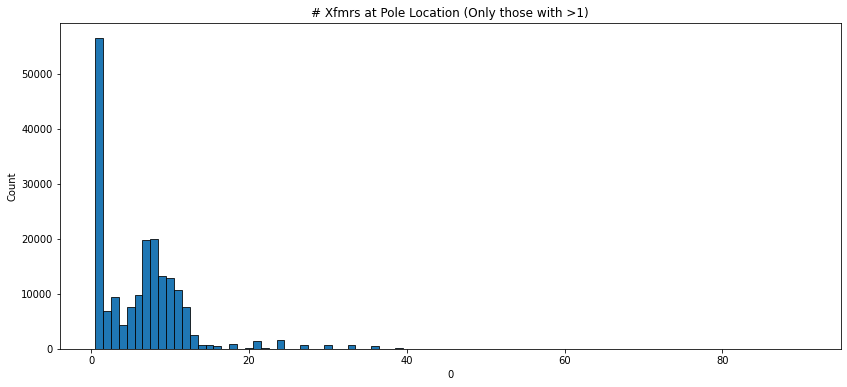

In [29]:
if merge_eemsp:
    fig,ax = Plot_General.default_subplots()
    Plot_Hist.plot_hist(
        ax=ax, 
        df=df_eemsp_reduce1.groupby('LOCATION_NB').size().to_frame(), 
        x_col=0, 
        min_max_and_bin_size=(0,10,1), 
        plot_sns=True, 
        hist_plot_kwargs=dict(discrete=True)
    )
    ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

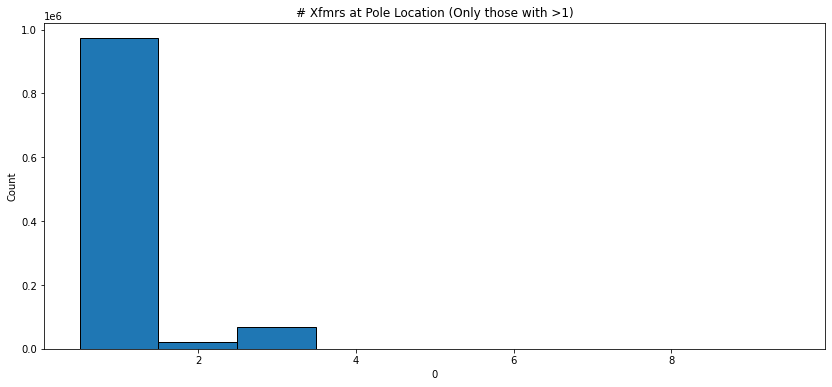

In [30]:
if merge_eemsp:
    fig,ax = Plot_General.default_subplots()
    Plot_Hist.plot_hist(
        ax=ax, 
        df=df_eemsp_reduce1.groupby(['LOCATION_NB', 'OUTG_REC_NB_TO_MERGE']).size().to_frame(), 
        x_col=0, 
        min_max_and_bin_size=(0,10,1), 
        plot_sns=True, 
        hist_plot_kwargs=dict(discrete=True)
    )
    ax.set_title('# Xfmrs at Pole Location (Only those with >1)')

In [31]:
if merge_eemsp:
    del df_eemsp_OG
    del df_eemsp_full
    del df_eemsp_reduce1
    del df_eemsp_reduce2

In [32]:
# REMOVING SCHEDULED OUTAGES

print(f'merged_df_full.shape = {merged_df_full.shape}')

merged_df_full =  MECPODf.get_cpo_df_subset_excluding_mjr_mnr_causes( 
    cpo_df=merged_df_full, 
    mjr_mnr_causes_to_exclude=None, 
    mjr_causes_to_exclude=None,
    mnr_causes_to_exclude=['SCO', 'SO'], 
    outg_rec_nb_col='index'
)

print(f'merged_df_full.shape = {merged_df_full.shape}')

merged_df_full.shape = (259732, 202)
n_coll = 18149
batch_size = 1000
n_batches = 19


C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

10/19


C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

merged_df_full.shape = (244086, 202)


In [33]:
merged_df_full.index.get_level_values(0).nunique()

13755

In [34]:
merged_df_full

01-06 Days  \
                           Access Point has lost connectivity with FHSS 900 MHz band   
outg_rec_nb trsf_pole_nb                                                               
12580837    1863938736669                                                 0.0          
12580900    40830909D30095                                                0.0          
            40830909D30135                                                0.0          
12580986    39830880B40002                                                0.0          
12580993    41820782A20052                                                0.0          
...                                                                       ...          
13149341    1863911752134                                                 0.0          
            1864266751554                                                 0.0          
            1864477751803                                                 0.0          
            1864504751367                                                 0.0          
13149360    41810795C40091                                                0.0          

                                                                     \
                           Demand Reset Detected end of voltage sag   
outg_rec_nb trsf_pole_nb                                              
12580837    1863938736669           0.0                         0.0   
12580900    40830909D30095          0.0                         0.0   
            40830909D30135          0.0                         0.0   
12580986    39830880B40002          0.0                         0.0   
12580993    41820782A20052          0.0                         0.0   
...                                 ...                         ...   
13149341    1863911752134           0.0                         0.0   
            1864266751554           0.0                         0.0   
            1864477751803           0.0                         0.0   
            1864504751367           0.0                         0.0   
13149360    41810795C40091          0.0                         0.0   

                                                                        \
                           Detected end of voltage swell Device Failed   
outg_rec_nb trsf_pole_nb                                                 
12580837    1863938736669                            0.0           0.0   
12580900    40830909D30095                           0.0           0.0   
            40830909D30135                           0.0           0.0   
12580986    39830880B40002                           0.0           0.0   
12580993    41820782A20052                           0.0           0.0   
...                                                  ...           ...   
13149341    1863911752134                            0.0           0.0   
            1864266751554                            0.0           0.0   
            1864477751803                            0.0           0.0   
            1864504751367                            0.0           0.0   
13149360    41810795C40091                           0.0           0.0   

                                                                             \
                           Device exceeded the max allowable trap threshold   
outg_rec_nb trsf_pole_nb                                                      
12580837    1863938736669                                               0.0   
12580900    40830909D30095                                              0.0   
            40830909D30135                                              0.0   
12580986    39830880B40002                                              0.0   
12580993    41820782A20052                                              0.0   
...                                                                     ...   
13149341    1863911752134                                               0.0   
            1864266

# Add month info

In [35]:
include_month = True
summary_dict['include_month'] = include_month

if include_month:
    merged_df_full_wd = DOVSOutages.append_outg_dt_off_ts_full_to_df(
        df=merged_df_full.copy(), 
        outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
        dummy_col_levels_prefix='dummy_lvl_'
    )
    #-------------------------
    merged_df_no_outg_wd = merge_cpx_df_w_time_infos(
        cpx_df=merged_df_no_outg.copy(), 
        time_infos_df=no_outg_time_infos_df, 
        time_infos_drop_dupls_subset=['index', 't_min']
    )
    #-----
    merged_df_no_outg_prstn_wd = merge_cpx_df_w_time_infos(
        cpx_df=merged_df_no_outg_prstn.copy(), 
        time_infos_df=no_outg_time_infos_prstn_df, 
        time_infos_drop_dupls_subset=['index', 't_min']
    )
    #-------------------------
    if ('is_outg', 'is_outg') in merged_df_full_wd.columns:
        merged_df_full_wd = Utilities_df.move_cols_to_back(merged_df_full_wd, [('is_outg', 'is_outg')])
    if ('is_outg', 'is_outg') in merged_df_no_outg_wd.columns:
        merged_df_no_outg_wd = Utilities_df.move_cols_to_back(merged_df_no_outg_wd, [('is_outg', 'is_outg')])
    if ('is_outg', 'is_outg') in merged_df_no_outg_prstn_wd.columns:
        merged_df_no_outg_prstn_wd = Utilities_df.move_cols_to_back(merged_df_no_outg_prstn_wd, [('is_outg', 'is_outg')])
    #-------------------------
    # Change outage time to just month of outage
    merged_df_full_wd[('dummy_lvl_0', 'outg_month')] = merged_df_full_wd[('dummy_lvl_0', 'DT_OFF_TS_FULL')].dt.month

    merged_df_no_outg_wd[('dummy_lvl_0', 'outg_month')] = merged_df_no_outg_wd[('dummy_lvl_0', 't_min')].dt.month
    merged_df_no_outg_prstn_wd[('dummy_lvl_0', 'outg_month')] = merged_df_no_outg_prstn_wd[('dummy_lvl_0', 't_min')].dt.month

    #-------------------------
    merged_df_full_wd = merged_df_full_wd.drop(columns=[('dummy_lvl_0', 'DT_OFF_TS_FULL')])
    merged_df_no_outg_wd = merged_df_no_outg_wd.drop(columns=[('dummy_lvl_0', 't_min'), ('dummy_lvl_0', 't_max'), ('dummy_lvl_0', 'prem_nbs')])
    merged_df_no_outg_prstn_wd = merged_df_no_outg_prstn_wd.drop(columns=[('dummy_lvl_0', 't_min'), ('dummy_lvl_0', 't_max'), ('dummy_lvl_0', 'prem_nbs')])
    #-------------------------
    merged_df_full=merged_df_full_wd.copy()
    merged_df_no_outg=merged_df_no_outg_wd.copy()
    merged_df_no_outg_prstn=merged_df_no_outg_prstn_wd.copy()

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

# !~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~

In [36]:
# Remove NETWORK and PRIMARY trsf_pole_nbs
# merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
# merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(0).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg=merged_df_no_outg.loc[~merged_df_no_outg.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
merged_df_no_outg_prstn=merged_df_no_outg_prstn.loc[~merged_df_no_outg_prstn.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]
#-----
merged_df_full=merged_df_full[~merged_df_full.index.get_level_values(1).isin(['NETWORK', 'PRIMARY'])]

In [37]:
# Get DOVS info to be used for setting target values
merged_df_full_w_DOVS = DOVSOutages.append_outg_info_to_df(
    df=merged_df_full.copy(), 
    outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
    build_sql_function=DOVSOutages_SQL.build_sql_std_outage, 
)
merged_df_full_w_DOVS=merged_df_full_w_DOVS[['outg_dummy_lvl_0']]
merged_df_full_w_DOVS[('is_outg', 'is_outg')]=0

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

In [38]:
# Add 'from_outg' information so I can track how many are in target=1 and target=0 
merged_df_full[('from_outg', 'from_outg')]          = 1
merged_df_no_outg[('from_outg', 'from_outg')]       = 0
merged_df_no_outg_prstn[('from_outg', 'from_outg')] = 0

In [39]:
an_keys

['01-06 Days',
 '06-11 Days',
 '11-16 Days',
 '16-21 Days',
 '21-26 Days',
 '26-31 Days']

# Drop any time periods

In [40]:
an_keys_to_drop = None
# an_keys_to_drop = ['00-01 Days']
# an_keys_to_drop = ['01-06 Days']

summary_dict['an_keys_to_drop'] = an_keys_to_drop

In [41]:
if an_keys_to_drop is not None:
    merged_df_full          = merged_df_full.drop(columns=an_keys_to_drop, level=0)
    merged_df_no_outg       = merged_df_no_outg.drop(columns=an_keys_to_drop, level=0)
    merged_df_no_outg_prstn = merged_df_no_outg_prstn.drop(columns=an_keys_to_drop, level=0)

In [42]:
date_0_train   = pd.to_datetime('2021-01-01')
date_1_train   = pd.to_datetime('2022-01-01')
#-----
date_0_test    = pd.to_datetime('2022-01-01')
date_1_test    = pd.to_datetime('2023-01-01')
#-----
date_0_HOLDOUT = pd.to_datetime('2022-06-01')
date_1_HOLDOUT = pd.to_datetime('2023-01-01')

# date_0_train   = pd.to_datetime('2021-01-01')
# date_1_train   = pd.to_datetime('2022-01-01')
# #-----
# date_0_test    = pd.to_datetime('2022-01-01')
# date_1_test    = pd.to_datetime('2022-06-01')
# #-----
# date_0_HOLDOUT = pd.to_datetime('2022-06-01')
# date_1_HOLDOUT = pd.to_datetime('2023-01-01')

# date_0_train   = pd.to_datetime('2020-01-01')
# date_1_train   = pd.to_datetime('2022-01-01')
# #-----
# date_0_test    = pd.to_datetime('2022-01-01')
# date_1_test    = pd.to_datetime('2022-01-01')
# #-----
# date_0_HOLDOUT = pd.to_datetime('2022-01-01')
# date_1_HOLDOUT = pd.to_datetime('2023-01-01')

In [43]:
get_train_test_by_date = False
split_train_test_by_outg = True 
random_state = None
test_size=0.33

In [44]:
# NOTE: Timestamp is not JSON serializable, hence the need for strftime below
summary_dict['date_0_train'] = date_0_train.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_train'] = date_1_train.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['date_0_test'] = date_0_test.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_test'] = date_1_test.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['date_0_HOLDOUT'] = date_0_HOLDOUT.strftime('%Y-%m-%d %H:%M:%S')
summary_dict['date_1_HOLDOUT'] = date_1_HOLDOUT.strftime('%Y-%m-%d %H:%M:%S')
#-----
summary_dict['get_train_test_by_date'] = get_train_test_by_date
summary_dict['split_train_test_by_outg'] = split_train_test_by_outg
#-----
summary_dict['random_state'] = random_state
summary_dict['test_size'] = test_size

In [45]:
if get_train_test_by_date:
    merged_df_full_train = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    merged_df_full_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
else:
    merged_df_full_train_test = get_cpx_outg_df_subset_by_outg_datetime(
        cpx_outg_df=merged_df_full.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        outg_rec_nb_idfr='index', 
        return_notin_also=False
    )
    #-----
    if split_train_test_by_outg:
        merged_df_full_train, merged_df_full_test = train_test_split_df_by_outage(
            df=merged_df_full_train_test, 
            outg_rec_nb_idfr=('index', 'outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_full_train, merged_df_full_test = train_test_split(
            merged_df_full_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------    
merged_df_full_HOLDOUT = get_cpx_outg_df_subset_by_outg_datetime(
    cpx_outg_df=merged_df_full.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    outg_rec_nb_idfr='index', 
    return_notin_also=False
)

C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn_db, **read_sql_args)
C:\Users\s346557\Documents\Analysis\GenAn.py:617: UserWarning: pandas only supp

In [46]:
if get_train_test_by_date:
    merged_df_no_outg_train = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg.copy(), 
        bsln_time_infos_df = no_outg_time_infos_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    #-----
    if split_train_test_by_outg:
        merged_df_no_outg_train, merged_df_no_outg_test = train_test_split_df_by_outage(
            df=merged_df_no_outg_train_test, 
            outg_rec_nb_idfr=('index', 'no_outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_no_outg_train, merged_df_no_outg_test = train_test_split(
            merged_df_no_outg_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------   
merged_df_no_outg_HOLDOUT = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg.copy(), 
    bsln_time_infos_df = no_outg_time_infos_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)
#--------------------------------------------------   
if get_train_test_by_date:
    merged_df_no_outg_prstn_train = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_train, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    merged_df_no_outg_prstn_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_test,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
else:
    merged_df_no_outg_prstn_train_test = get_cpx_baseline_df_subset_by_datetime(
        cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
        bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
        date_0 = date_0_train,
        date_1 = date_1_test, 
        bsln_time_infos_time_col='t_min', 
        return_notin_also=False, 
        merge_time_info_to_cpx_bsln_df=False
    )
    if split_train_test_by_outg:
        merged_df_no_outg_prstn_train, merged_df_no_outg_prstn_test = train_test_split(
            merged_df_no_outg_prstn_train_test, 
            test_size=test_size, 
            random_state=random_state
        )
    else:
        merged_df_no_outg_prstn_train, merged_df_no_outg_prstn_test = train_test_split_df_by_outage(
            df=merged_df_no_outg_prstn_train_test, 
            outg_rec_nb_idfr=('index', 'no_outg_rec_nb'), 
            test_size=test_size, 
            random_state=random_state
        )
#-------------------------   
merged_df_no_outg_prstn_HOLDOUT = get_cpx_baseline_df_subset_by_datetime(
    cpx_bsln_df = merged_df_no_outg_prstn.copy(), 
    bsln_time_infos_df = no_outg_time_infos_prstn_df.copy(), 
    date_0 = date_0_HOLDOUT,
    date_1 = date_1_HOLDOUT, 
    bsln_time_infos_time_col='t_min', 
    return_notin_also=False, 
    merge_time_info_to_cpx_bsln_df=False
)

In [47]:
addtnl_baseline_train = pd.concat([merged_df_no_outg_train, merged_df_no_outg_prstn_train])
# addtnl_baseline_train = addtnl_baseline_train.sample(frac=0.10)

addtnl_baseline_test = pd.concat([merged_df_no_outg_test, merged_df_no_outg_prstn_test])
# addtnl_baseline_test = addtnl_baseline_test.sample(frac=0.10)

addtnl_baseline_HOLDOUT = pd.concat([merged_df_no_outg_HOLDOUT, merged_df_no_outg_prstn_HOLDOUT])
# addtnl_baseline_HOLDOUT = addtnl_baseline_HOLDOUT.sample(frac=0.10)

In [48]:
full_data_df_train   = pd.concat([merged_df_full_train, addtnl_baseline_train])
full_data_df_test    = pd.concat([merged_df_full_test, addtnl_baseline_test])
full_data_df_HOLDOUT = pd.concat([merged_df_full_HOLDOUT, addtnl_baseline_HOLDOUT])

#Shuffle the data
full_data_df_train   = full_data_df_train.sample(frac=1)
full_data_df_test    = full_data_df_test.sample(frac=1)
full_data_df_HOLDOUT = full_data_df_HOLDOUT.sample(frac=1)

full_data_df = pd.concat([full_data_df_train, full_data_df_test, full_data_df_HOLDOUT])

# =========================================================
# =========================================================

In [49]:
#NOTE!!!!!!!!!!!!!
# If using _v2, SHOULD NOT SCALE events_period column!!!!!!!!!!!!

create_validation_set = False
val_size = 0.10 #w.r.t to train size (i.e., w.r.t 1.0-test_size)

run_scaler=True

run_PCA = False
pca_n_components=0.95

In [50]:
summary_dict['create_validation_set'] = create_validation_set
summary_dict['val_size']              = val_size
summary_dict['run_scaler']            = run_scaler
summary_dict['run_PCA']               = run_PCA
summary_dict['pca_n_components']      = pca_n_components

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [51]:
# if merge_eemsp:
#     full_data_df         = full_data_df.drop(columns=[('key_0', '')])
#     full_data_df_train   = full_data_df_train.drop(columns=[('key_0', '')])
#     full_data_df_test    = full_data_df_test.drop(columns=[('key_0', '')])
#     full_data_df_HOLDOUT = full_data_df_HOLDOUT.drop(columns=[('key_0', '')])
    
#     le = preprocessing.LabelEncoder()
#     cols_to_encode = full_data_df['EEMSP'].columns
#     for col in cols_to_encode:
#         le.fit(full_data_df[('EEMSP', col)])
#         #-----
#         full_data_df_train[('EEMSP', col)]   = le.transform(full_data_df_train[('EEMSP', col)])
#         full_data_df_test[('EEMSP', col)]    = le.transform(full_data_df_test[('EEMSP', col)])
#         full_data_df_HOLDOUT[('EEMSP', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP', col)])

if merge_eemsp:    
    le = preprocessing.LabelEncoder()
    cols_to_encode = full_data_df['EEMSP_0'].columns
    numeric_cols = ['KVA_SIZE']
    cols_to_encode = [x for x in cols_to_encode if x not in numeric_cols]
    for col in cols_to_encode:
        full_data_df[('EEMSP_0', col)]         = full_data_df[('EEMSP_0', col)].astype(str)
        full_data_df_train[('EEMSP_0', col)]   = full_data_df_train[('EEMSP_0', col)].astype(str)
        full_data_df_test[('EEMSP_0', col)]    = full_data_df_test[('EEMSP_0', col)].astype(str)
        full_data_df_HOLDOUT[('EEMSP_0', col)] = full_data_df_HOLDOUT[('EEMSP_0', col)].astype(str)
        #-----
        le.fit(full_data_df[('EEMSP_0', col)])
        #-----
        full_data_df_train[('EEMSP_0', col)]   = le.transform(full_data_df_train[('EEMSP_0', col)])
        full_data_df_test[('EEMSP_0', col)]    = le.transform(full_data_df_test[('EEMSP_0', col)])
        full_data_df_HOLDOUT[('EEMSP_0', col)] = le.transform(full_data_df_HOLDOUT[('EEMSP_0', col)])

In [52]:
remove_others_from_outages=False

# min_pct_target_1 = 25
min_pct_target_1 = None

min_sbgrp_tar_1_size = 1000

In [53]:
summary_dict['remove_others_from_outages'] = remove_others_from_outages
summary_dict['min_pct_target_1'] = min_pct_target_1

In [54]:
reduce_train_size = False
red_test_size = 0.75 #Amount kept will be 1.0-red_test_size
summary_dict['reduce_train_size'] = reduce_train_size
summary_dict['red_test_size'] = red_test_size

In [55]:
summary_df = pd.DataFrame(columns=[
    'name', 
    'n_1_train', 'n_0_train', 'pct_1_train', 'acc_train', 'prec_train', 'rec_train', 
    'n_1_test',  'n_0_test',  'pct_1_test',  'acc_test',  'prec_test',  'rec_test' 
])

In [56]:
# mjr_mnr_causes = list(merged_df_full_w_DOVS.groupby([('outg_dummy_lvl_0', 'MJR_CAUSE_NM'), ('outg_dummy_lvl_0', 'MNR_CAUSE_NM')]).groups.keys())
mjr_mnr_causes = merged_df_full_w_DOVS[[('outg_dummy_lvl_0', 'MJR_CAUSE_NM'), ('outg_dummy_lvl_0', 'MNR_CAUSE_NM')]].value_counts(dropna=False).index.tolist()
for mjr_cause,mnr_cause in mjr_mnr_causes:
    print('#####'*20)
    print(mjr_cause)
    print(mnr_cause)
    slicer = DFSlicer(
        single_slicers = [
            dict(
                column=('outg_dummy_lvl_0', 'MJR_CAUSE_NM'), 
                value=mjr_cause, 
                comparison_operator='=='
            ), 
            dict(
                column=('outg_dummy_lvl_0', 'MNR_CAUSE_NM'), 
                value=mnr_cause, 
                comparison_operator='=='
            )
        ], 
        name=f"MJR_MNR_CAUSE_{mjr_cause}_{mnr_cause}"
    )
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    merged_df_full_w_DOVS_i = slicer.set_simple_column_value(df=merged_df_full_w_DOVS.copy(), column=('is_outg', 'is_outg'), value=1)
    full_outg_idxs_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==1].index

    if merged_df_full_w_DOVS_i[('is_outg', 'is_outg')].sum() < min_sbgrp_tar_1_size:
        print('Not enough target==1 values!  Not running model fit')
        print(f"#target==1:           {merged_df_full_w_DOVS_i[('is_outg', 'is_outg')].sum()}")
        print(f'min_sbgrp_tar_1_size: {min_sbgrp_tar_1_size}')
        continue


    #--------------------------------------------------

    #-------------------------
    full_data_df_i         = full_data_df.copy()
    full_data_df_train_i   = full_data_df_train.copy()
    full_data_df_test_i    = full_data_df_test.copy()
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT.copy()
    #-------------------------
    full_data_df_i = set_target_val_1_by_idx(
        df=full_data_df_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_train_i = set_target_val_1_by_idx(
        df=full_data_df_train_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_test_i = set_target_val_1_by_idx(
        df=full_data_df_test_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_HOLDOUT_i = set_target_val_1_by_idx(
        df=full_data_df_HOLDOUT_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    
    #--------------------------------------------------
    if (
        full_data_df_train_i[('is_outg', 'is_outg')].sum()==0 or 
        full_data_df_test_i[('is_outg', 'is_outg')].sum()==0 or 
        full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()==0
    ):
        print('Not enough target value==1 in train, test, and/or holdout')
        print(f"#target==1 train:   {full_data_df_train_i[('is_outg', 'is_outg')].sum()}")
        print(f"#target==1 test:    {full_data_df_test_i[('is_outg', 'is_outg')].sum()}")
        print(f"#target==1 holdout: {full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()}")
        continue    


    #--------------------------------------------------
    if min_pct_target_1 is not None:
        full_data_df_train_i = ensure_target_val_1_min_pct(
            df=full_data_df_train_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----
        full_data_df_test_i = ensure_target_val_1_min_pct(
            df=full_data_df_test_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----
        full_data_df_HOLDOUT_i = ensure_target_val_1_min_pct(
            df=full_data_df_HOLDOUT_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----


    #--------------------------------------------------
    #--------------------------------------------------
    n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_train = full_data_df_train_i[
        (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_train_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
    pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
    #-----
    print('\n----- TRAIN -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
    print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
    print(f"# additional baseline (target = 0): {n_bsln_train}")
    print(f"%(target==1):                       {pct_target_1_train}%")

    #--------------------------------------------------
    n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_test = full_data_df_test_i[
        (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_test_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
    pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
    #-----
    print('\n----- TEST -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
    print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
    print(f"# additional baseline (target = 0): {n_bsln_test}")
    print(f"%(target==1):                       {pct_target_1_test}%")

    #--------------------------------------------------
    n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
        (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
    pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
    #-----
    print('\n----- HOLDOUT -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
    print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
    print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
    print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")


    #--------------------------------------------------
    if ('from_outg', 'from_outg') in full_data_df_i.columns.tolist():
        full_data_df_i = full_data_df_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_train_i.columns.tolist():
        full_data_df_train_i = full_data_df_train_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_test_i.columns.tolist():
        full_data_df_test_i = full_data_df_test_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_HOLDOUT_i.columns.tolist():
        full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=[('from_outg', 'from_outg')])

    #--------------------------------------------------
    if reduce_train_size:
        if split_train_test_by_outg:
            full_data_df_train_i, _ = train_test_split_df_by_outage(
                df=full_data_df_train_i, 
                outg_rec_nb_idfr='index_0', 
                test_size=red_test_size, 
                random_state=random_state
            )
        else:
            full_data_df_train_i, _ = train_test_split(
                full_data_df_train_i, 
                test_size=red_test_size, 
                random_state=random_state
            )
        
    #--------------------------------------------------
    print('Running dropna')
    print(full_data_df_train_i.shape[0])
    full_data_df_train_i = full_data_df_train_i.dropna()
    print(full_data_df_train_i.shape[0])
    print()
    #-----
    print(full_data_df_test_i.shape[0])
    full_data_df_test_i = full_data_df_test_i.dropna()
    print(full_data_df_test_i.shape[0])
    print()
    #-----
    print(full_data_df_HOLDOUT_i.shape[0])
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.dropna()
    print(full_data_df_HOLDOUT_i.shape[0])
    print()
    #-----    
    
    #--------------------------------------------------
    #-------------------------
    X_train_OG = full_data_df_train_i.iloc[:, :-1].copy()
    y_train    = full_data_df_train_i.iloc[:, -1].copy()

    X_test_OG = full_data_df_test_i.iloc[:, :-1].copy()
    y_test    = full_data_df_test_i.iloc[:, -1].copy()

    X_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, :-1]
    y_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, -1]


    #--------------------------------------------------
    #-------------------------
    if create_validation_set:
        if split_train_test_by_outg:
            X_train_OG, X_val_OG, y_train, y_val = train_test_split_df_group(
                X=X_train_OG, 
                y=y_train, 
                groups=X_train_OG.index.get_level_values(0), 
                test_size=val_size, 
                random_state=random_state
            )
        else:
            X_train_OG, X_val_OG, y_train, y_val = train_test_split(X_train_OG, y_train, test_size=val_size, random_state=random_state)
    #-------------------------
    if run_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_OG)
        #-----
        if create_validation_set:
            X_val   = scaler.transform(X_val_OG)
        X_test  = scaler.transform(X_test_OG)
        X_HOLDOUT   = scaler.transform(X_HOLDOUT)
    else:
        X_train = X_train_OG
        if create_validation_set:
            X_val   = X_val_OG
        X_test  = X_test_OG


    #--------------------------------------------------
    if run_PCA:
        # First, generate a PCA plot, showing the explained variance on the y-axis and number of components on x
        # This is simply to check that the number of components kept looks correct
        pca = PCA()
        pca.fit(X_train)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(cumsum)

        # Now, run the PCA with pca_n_components and perform transforms
        pca=PCA(n_components=pca_n_components)
        X_train = pca.fit_transform(X_train)
        print(f'PCA n-components       = {pca.n_components_}')
        print(f'PCA explained variance = {pca.explained_variance_ratio_.sum()}')
        #-----
        if create_validation_set:
            X_val      = pca.transform(X_val)
        X_test     = pca.transform(X_test)
        X_HOLDOUT  = pca.transform(X_HOLDOUT)


    #--------------------------------------------------
    # forest_clf = RandomForestClassifier(n_estimators = 100)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', n_jobs=-1)

    # forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None)
    forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=None, n_jobs=None)


    #--------------------------------------------------
    start = time.time()
    forest_clf.fit(X_train, y_train)
    print(time.time()-start)


    #--------------------------------------------------
    y_pred_train = forest_clf.predict(X_train)
    print('*****'*5)
    print('TRAINING DATASET')
    print('*****'*5)
    print(f"#(target==1): {y_train.sum()}")
    print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
    print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
    print('-----'*5)
    print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
    print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
    print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
    print()

    y_pred = forest_clf.predict(X_test)
    print('*****'*5)
    print('TESTING DATASET')
    print('*****'*5)
    print(f"#(target==1): {y_test.sum()}")
    print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
    print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
    print('-----'*5)
    print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
    print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
    print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
    print()

#     y_pred_HOLDOUT = forest_clf.predict(X_HOLDOUT)
#     print('*****'*5)
#     print('HOLDOOUT DATASET')
#     print('*****'*5)
#     print(f"#(target==1): {y_HOLDOUT.sum()}")
#     print(f"#(target==0): {y_HOLDOUT.shape[0]-y_HOLDOUT.sum()}")
#     print(f"%(target==1): {100*(y_HOLDOUT.sum()/(y_HOLDOUT.shape[0]))}")
#     print('-----'*5)
#     print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
#     print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
#     print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))
    
    #--------------------------------------------------
    summary_df = pd.concat([
        summary_df, 
        pd.DataFrame(dict(
            name=slicer.name, 

            n_1_train   = y_train.sum(), 
            n_0_train   = y_train.shape[0]-y_train.sum(), 
            pct_1_train = 100*(y_train.sum()/(y_train.shape[0])), 
            acc_train   = accuracy_score(y_train, y_pred_train), 
            prec_train  = precision_score(y_train, y_pred_train), 
            rec_train   = recall_score(y_train, y_pred_train), 

            n_1_test   = y_test.sum(), 
            n_0_test   = y_test.shape[0]-y_test.sum(), 
            pct_1_test = 100*(y_test.sum()/(y_test.shape[0])), 
            acc_test   = accuracy_score(y_test, y_pred), 
            prec_test  = precision_score(y_test, y_pred), 
            rec_test   = recall_score(y_test, y_pred), 
        ), index=[summary_df.shape[0]])]
    )


####################################################################################################
DISTRIBUTION LINE
EQUIPMENT FAILURE

----- TRAIN -----
# direct outages (target = 1):      33539
# indirect outages (target = 0):    125340
	% direct = 21.109775363641514
# additional baseline (target = 0): 464814
%(target==1):                       5.377485397463175%

----- TEST -----
# direct outages (target = 1):      16391
# indirect outages (target = 0):    68816
	% direct = 19.236682432194538
# additional baseline (target = 0): 228939
%(target==1):                       5.217637658922921%

----- HOLDOUT -----
# direct outages (target = 1):      29767
# indirect outages (target = 0):    145572
	% direct = 16.9768277451109
# additional baseline (target = 0): 506799
%(target==1):                       4.36377976303915%
Running dropna
623693
623693

314146
314146

682138
682138

3056.894706964493
*************************
TRAINING DATASET
*************************
#(target==1): 33539


Running dropna
623693
623693

314146
314146

682138
682138

2284.5809762477875
*************************
TRAINING DATASET
*************************
#(target==1): 9986
#(target==0): 613707
%(target==1): 1.601108237546357
-------------------------
ACCURACY  OF THE MODEL:  0.999967932941367
PRECISION OF THE MODEL:  1.0
RECALL    OF THE MODEL:  0.9979971960745043

*************************
TESTING DATASET
*************************
#(target==1): 4240
#(target==0): 309906
%(target==1): 1.3496909080491237
-------------------------
ACCURACY  OF THE MODEL:  0.9862547987241601
PRECISION OF THE MODEL:  0.024390243902439025
RECALL    OF THE MODEL:  0.0004716981132075472

####################################################################################################
DISTRIBUTION STATION
EQUIPMENT FAILURE

----- TRAIN -----
# direct outages (target = 1):      5628
# indirect outages (target = 0):    153251
	% direct = 3.5423183680662644
# additional baseline (target = 0): 464814
%(target==1):  

RECALL    OF THE MODEL:  0.005563282336578581

####################################################################################################
DISTRIBUTION LINE
ERROR - FIELD

----- TRAIN -----
# direct outages (target = 1):      2308
# indirect outages (target = 0):    156571
	% direct = 1.4526778240044311
# additional baseline (target = 0): 464814
%(target==1):                       0.37005385662497414%

----- TEST -----
# direct outages (target = 1):      1422
# indirect outages (target = 0):    83785
	% direct = 1.6688769702019788
# additional baseline (target = 0): 228939
%(target==1):                       0.45265577152024855%

----- HOLDOUT -----
# direct outages (target = 1):      2011
# indirect outages (target = 0):    173328
	% direct = 1.1469211071125078
# additional baseline (target = 0): 506799
%(target==1):                       0.294808381881672%
Running dropna
623693
623693

314146
314146

682138
682138

1903.0318117141724
*************************
TRAINING DATASE

Running dropna
623693
623693

314146
314146

682138
682138

1547.6543221473694
*************************
TRAINING DATASET
*************************
#(target==1): 1495
#(target==0): 622198
%(target==1): 0.23970126328177482
-------------------------
ACCURACY  OF THE MODEL:  0.9998813518830578
PRECISION OF THE MODEL:  0.9985964912280701
RECALL    OF THE MODEL:  0.9518394648829431

*************************
TESTING DATASET
*************************
#(target==1): 561
#(target==0): 313585
%(target==1): 0.17857938665461282
-------------------------
ACCURACY  OF THE MODEL:  0.9981187091352428
PRECISION OF THE MODEL:  0.03125
RECALL    OF THE MODEL:  0.0017825311942959

####################################################################################################
DISTRIBUTION STATION
ABNORMAL FEED

----- TRAIN -----
# direct outages (target = 1):      783
# indirect outages (target = 0):    158096
	% direct = 0.49282787530132993
# additional baseline (target = 0): 464814
%(target==1):    

RECALL    OF THE MODEL:  0.0

####################################################################################################
TRANSMISSION LINE
TREE OUT OF ROW

----- TRAIN -----
# direct outages (target = 1):      876
# indirect outages (target = 0):    158003
	% direct = 0.5513629869271583
# additional baseline (target = 0): 464814
%(target==1):                       0.1404537168125985%

----- TEST -----
# direct outages (target = 1):      311
# indirect outages (target = 0):    84896
	% direct = 0.3649934864506437
# additional baseline (target = 0): 228939
%(target==1):                       0.09899855481209374%

----- HOLDOUT -----
# direct outages (target = 1):      568
# indirect outages (target = 0):    174771
	% direct = 0.32394390295370684
# additional baseline (target = 0): 506799
%(target==1):                       0.08326760860705605%
Running dropna
623693
623693

314146
314146

682138
682138

1031.4995925426483
*************************
TRAINING DATASET
**************

Not enough target==1 values!  Not running model fit
#target==1:           323
min_sbgrp_tar_1_size: 1000
####################################################################################################
TRANSMISSION LINE
WEATHER - HIGH WINDS (EXCEEDING 60 MPH)
Not enough target==1 values!  Not running model fit
#target==1:           315
min_sbgrp_tar_1_size: 1000
####################################################################################################
DISTRIBUTION LINE
VINE
Not enough target==1 values!  Not running model fit
#target==1:           270
min_sbgrp_tar_1_size: 1000
####################################################################################################
PARTIAL POWER
TREE OUT OF ROW
Not enough target==1 values!  Not running model fit
#target==1:           239
min_sbgrp_tar_1_size: 1000
####################################################################################################
DISTRIBUTION LINE
TREE REMOVAL (NON AEP)
Not enough target==1 val

Not enough target==1 values!  Not running model fit
#target==1:           3
min_sbgrp_tar_1_size: 1000
####################################################################################################
PARTIAL POWER
WEATHER - LIGHTNING
Not enough target==1 values!  Not running model fit
#target==1:           2
min_sbgrp_tar_1_size: 1000
####################################################################################################
PARTIAL POWER
WEATHER - ICE (1/2 INCH OR > 6 " SNOW)
Not enough target==1 values!  Not running model fit
#target==1:           2
min_sbgrp_tar_1_size: 1000
####################################################################################################
TRANSMISSION LINE
UNKNOWN (NON WEATHER)
Not enough target==1 values!  Not running model fit
#target==1:           2
min_sbgrp_tar_1_size: 1000
####################################################################################################
PARTIAL POWER
VANDALISM
Not enough target==1 values!  Not

In [57]:
# equip_typ_nms = merged_df_full_w_DOVS[('outg_dummy_lvl_0', 'EQUIP_TYP_NM')].unique().tolist()
equip_typ_nms = merged_df_full_w_DOVS[('outg_dummy_lvl_0', 'EQUIP_TYP_NM')].value_counts(dropna=False).index.tolist()
for equip_typ_nm in equip_typ_nms:
    print('#####'*20)
    print(equip_typ_nm)
    slicer = DFSlicer(
        single_slicers = [
            dict(
                column=('outg_dummy_lvl_0', 'EQUIP_TYP_NM'), 
                value=equip_typ_nm, 
                comparison_operator='=='
            )
        ], 
        name=f"EQUIP_TYP_NM_{equip_typ_nm}"
    )
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    merged_df_full_w_DOVS_i = slicer.set_simple_column_value(df=merged_df_full_w_DOVS.copy(), column=('is_outg', 'is_outg'), value=1)
    full_outg_idxs_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==1].index

    if merged_df_full_w_DOVS_i[('is_outg', 'is_outg')].sum() < min_sbgrp_tar_1_size:
        print('Not enough target==1 values!  Not running model fit')
        print(f"#target==1:           {merged_df_full_w_DOVS_i[('is_outg', 'is_outg')].sum()}")
        print(f'min_sbgrp_tar_1_size: {min_sbgrp_tar_1_size}')
        continue


    #--------------------------------------------------

    #-------------------------
    full_data_df_i         = full_data_df.copy()
    full_data_df_train_i   = full_data_df_train.copy()
    full_data_df_test_i    = full_data_df_test.copy()
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT.copy()
    #-------------------------
    full_data_df_i = set_target_val_1_by_idx(
        df=full_data_df_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_train_i = set_target_val_1_by_idx(
        df=full_data_df_train_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_test_i = set_target_val_1_by_idx(
        df=full_data_df_test_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_HOLDOUT_i = set_target_val_1_by_idx(
        df=full_data_df_HOLDOUT_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )

    #--------------------------------------------------
    if (
        full_data_df_train_i[('is_outg', 'is_outg')].sum()==0 or 
        full_data_df_test_i[('is_outg', 'is_outg')].sum()==0 or 
        full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()==0
    ):
        print('Not enough target value==1 in train, test, and/or holdout')
        print(f"#target==1 train:   {full_data_df_train_i[('is_outg', 'is_outg')].sum()}")
        print(f"#target==1 test:    {full_data_df_test_i[('is_outg', 'is_outg')].sum()}")
        print(f"#target==1 holdout: {full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()}")
        continue

    #--------------------------------------------------
    if min_pct_target_1 is not None:
        full_data_df_train_i = ensure_target_val_1_min_pct(
            df=full_data_df_train_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----
        full_data_df_test_i = ensure_target_val_1_min_pct(
            df=full_data_df_test_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----
        full_data_df_HOLDOUT_i = ensure_target_val_1_min_pct(
            df=full_data_df_HOLDOUT_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----


    #--------------------------------------------------
    #--------------------------------------------------
    n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_train = full_data_df_train_i[
        (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_train_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
    pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
    #-----
    print('\n----- TRAIN -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
    print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
    print(f"# additional baseline (target = 0): {n_bsln_train}")
    print(f"%(target==1):                       {pct_target_1_train}%")

    #--------------------------------------------------
    n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_test = full_data_df_test_i[
        (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_test_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
    pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
    #-----
    print('\n----- TEST -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
    print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
    print(f"# additional baseline (target = 0): {n_bsln_test}")
    print(f"%(target==1):                       {pct_target_1_test}%")

    #--------------------------------------------------
    n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
        (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
    pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
    #-----
    print('\n----- HOLDOUT -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
    print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
    print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
    print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")


    #--------------------------------------------------
    if ('from_outg', 'from_outg') in full_data_df_i.columns.tolist():
        full_data_df_i = full_data_df_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_train_i.columns.tolist():
        full_data_df_train_i = full_data_df_train_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_test_i.columns.tolist():
        full_data_df_test_i = full_data_df_test_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_HOLDOUT_i.columns.tolist():
        full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=[('from_outg', 'from_outg')])

    #--------------------------------------------------
    if reduce_train_size:
        if split_train_test_by_outg:
            full_data_df_train_i, _ = train_test_split_df_by_outage(
                df=full_data_df_train_i, 
                outg_rec_nb_idfr='index_0', 
                test_size=red_test_size, 
                random_state=random_state
            )
        else:
            full_data_df_train_i, _ = train_test_split(
                full_data_df_train_i, 
                test_size=red_test_size, 
                random_state=random_state
            )
        
    #--------------------------------------------------
    print('Running dropna')
    print(full_data_df_train_i.shape[0])
    full_data_df_train_i = full_data_df_train_i.dropna()
    print(full_data_df_train_i.shape[0])
    print()
    #-----
    print(full_data_df_test_i.shape[0])
    full_data_df_test_i = full_data_df_test_i.dropna()
    print(full_data_df_test_i.shape[0])
    print()
    #-----
    print(full_data_df_HOLDOUT_i.shape[0])
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.dropna()
    print(full_data_df_HOLDOUT_i.shape[0])
    print()
    #-----    
        
    #--------------------------------------------------
    #-------------------------
    X_train_OG = full_data_df_train_i.iloc[:, :-1].copy()
    y_train    = full_data_df_train_i.iloc[:, -1].copy()

    X_test_OG = full_data_df_test_i.iloc[:, :-1].copy()
    y_test    = full_data_df_test_i.iloc[:, -1].copy()

    X_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, :-1]
    y_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, -1]


    #--------------------------------------------------
    #-------------------------
    if create_validation_set:
        if split_train_test_by_outg:
            X_train_OG, X_val_OG, y_train, y_val = train_test_split_df_group(
                X=X_train_OG, 
                y=y_train, 
                groups=X_train_OG.index.get_level_values(0), 
                test_size=val_size, 
                random_state=random_state
            )
        else:
            X_train_OG, X_val_OG, y_train, y_val = train_test_split(X_train_OG, y_train, test_size=val_size, random_state=random_state)
    #-------------------------
    if run_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_OG)
        #-----
        if create_validation_set:
            X_val   = scaler.transform(X_val_OG)
        X_test  = scaler.transform(X_test_OG)
        X_HOLDOUT   = scaler.transform(X_HOLDOUT)
    else:
        X_train = X_train_OG
        if create_validation_set:
            X_val   = X_val_OG
        X_test  = X_test_OG


    #--------------------------------------------------
    if run_PCA:
        # First, generate a PCA plot, showing the explained variance on the y-axis and number of components on x
        # This is simply to check that the number of components kept looks correct
        pca = PCA()
        pca.fit(X_train)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(cumsum)

        # Now, run the PCA with pca_n_components and perform transforms
        pca=PCA(n_components=pca_n_components)
        X_train = pca.fit_transform(X_train)
        print(f'PCA n-components       = {pca.n_components_}')
        print(f'PCA explained variance = {pca.explained_variance_ratio_.sum()}')
        #-----
        if create_validation_set:
            X_val      = pca.transform(X_val)
        X_test     = pca.transform(X_test)
        X_HOLDOUT  = pca.transform(X_HOLDOUT)


    #--------------------------------------------------
    # forest_clf = RandomForestClassifier(n_estimators = 100)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', n_jobs=-1)

    # forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None)
    forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=None, n_jobs=None)


    #--------------------------------------------------
    start = time.time()
    forest_clf.fit(X_train, y_train)
    print(time.time()-start)


    #--------------------------------------------------
    y_pred_train = forest_clf.predict(X_train)
    print('*****'*5)
    print('TRAINING DATASET')
    print('*****'*5)
    print(f"#(target==1): {y_train.sum()}")
    print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
    print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
    print('-----'*5)
    print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
    print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
    print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
    print()

    y_pred = forest_clf.predict(X_test)
    print('*****'*5)
    print('TESTING DATASET')
    print('*****'*5)
    print(f"#(target==1): {y_test.sum()}")
    print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
    print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
    print('-----'*5)
    print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
    print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
    print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
    print()

#     y_pred_HOLDOUT = forest_clf.predict(X_HOLDOUT)
#     print('*****'*5)
#     print('HOLDOOUT DATASET')
#     print('*****'*5)
#     print(f"#(target==1): {y_HOLDOUT.sum()}")
#     print(f"#(target==0): {y_HOLDOUT.shape[0]-y_HOLDOUT.sum()}")
#     print(f"%(target==1): {100*(y_HOLDOUT.sum()/(y_HOLDOUT.shape[0]))}")
#     print('-----'*5)
#     print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
#     print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
#     print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))

    #--------------------------------------------------
    summary_df = pd.concat([
        summary_df, 
        pd.DataFrame(dict(
            name=slicer.name, 

            n_1_train   = y_train.sum(), 
            n_0_train   = y_train.shape[0]-y_train.sum(), 
            pct_1_train = 100*(y_train.sum()/(y_train.shape[0])), 
            acc_train   = accuracy_score(y_train, y_pred_train), 
            prec_train  = precision_score(y_train, y_pred_train), 
            rec_train   = recall_score(y_train, y_pred_train), 

            n_1_test   = y_test.sum(), 
            n_0_test   = y_test.shape[0]-y_test.sum(), 
            pct_1_test = 100*(y_test.sum()/(y_test.shape[0])), 
            acc_test   = accuracy_score(y_test, y_pred), 
            prec_test  = precision_score(y_test, y_pred), 
            rec_test   = recall_score(y_test, y_pred), 
        ), index=[summary_df.shape[0]])]
    )

####################################################################################################
NONE

----- TRAIN -----
# direct outages (target = 1):      72843
# indirect outages (target = 0):    86036
	% direct = 45.84809823828196
# additional baseline (target = 0): 464814
%(target==1):                       11.67930376002296%

----- TEST -----
# direct outages (target = 1):      43290
# indirect outages (target = 0):    41917
	% direct = 50.805684978933655
# additional baseline (target = 0): 228939
%(target==1):                       13.780216841850605%

----- HOLDOUT -----
# direct outages (target = 1):      92408
# indirect outages (target = 0):    82931
	% direct = 52.70247919744039
# additional baseline (target = 0): 506799
%(target==1):                       13.546818972114147%
Running dropna
623693
623693

314146
314146

682138
682138

3023.1843411922455
*************************
TRAINING DATASET
*************************
#(target==1): 72843
#(target==0): 550850
%(target

Running dropna
623693
623693

314146
314146

682138
682138

2170.8222630023956
*************************
TRAINING DATASET
*************************
#(target==1): 4679
#(target==0): 619014
%(target==1): 0.7502088367193475
-------------------------
ACCURACY  OF THE MODEL:  0.9999823631177518
PRECISION OF THE MODEL:  1.0
RECALL    OF THE MODEL:  0.9976490703141697

*************************
TESTING DATASET
*************************
#(target==1): 3244
#(target==0): 310902
%(target==1): 1.0326408739885278
-------------------------
ACCURACY  OF THE MODEL:  0.9895398954626193
PRECISION OF THE MODEL:  0.20833333333333334
RECALL    OF THE MODEL:  0.004623921085080148

####################################################################################################
SWITCH, OH

----- TRAIN -----
# direct outages (target = 1):      4269
# indirect outages (target = 0):    154610
	% direct = 2.686950446566255
# additional baseline (target = 0): 464814
%(target==1):                       0.684471


----- TEST -----
# direct outages (target = 1):      1300
# indirect outages (target = 0):    83907
	% direct = 1.5256962456136234
# additional baseline (target = 0): 228939
%(target==1):                       0.4138203255810992%

----- HOLDOUT -----
# direct outages (target = 1):      2864
# indirect outages (target = 0):    172475
	% direct = 1.6334072853158739
# additional baseline (target = 0): 506799
%(target==1):                       0.41985639269473335%
Running dropna
623693
623693

314146
314146

682138
682138

1936.2033834457397
*************************
TRAINING DATASET
*************************
#(target==1): 2435
#(target==0): 621258
%(target==1): 0.3904164388569376
-------------------------
ACCURACY  OF THE MODEL:  0.9998188211187234
PRECISION OF THE MODEL:  0.9987113402061856
RECALL    OF THE MODEL:  0.9548254620123203

*************************
TESTING DATASET
*************************
#(target==1): 1300
#(target==0): 312846
%(target==1): 0.4138203255810992
------------

C:\Users\s346557\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRECISION OF THE MODEL:  0.0
RECALL    OF THE MODEL:  0.0



C:\Users\s346557\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####################################################################################################
OTHER EQUIPMENT

----- TRAIN -----
# direct outages (target = 1):      1771
# indirect outages (target = 0):    157108
	% direct = 1.1146847601004537
# additional baseline (target = 0): 464814
%(target==1):                       0.2839538041953333%

----- TEST -----
# direct outages (target = 1):      412
# indirect outages (target = 0):    84795
	% direct = 0.483528348609856
# additional baseline (target = 0): 228939
%(target==1):                       0.13114921087647144%

----- HOLDOUT -----
# direct outages (target = 1):      1832
# indirect outages (target = 0):    173507
	% direct = 1.0448331517802656
# additional baseline (target = 0): 506799
%(target==1):                       0.2685673573382512%
Running dropna
623693
623693

314146
314146

682138
682138

1521.5891847610474
*************************
TRAINING DATASET
*************************
#(target==1): 1771
#(target==0): 6219

#target==1:           538
min_sbgrp_tar_1_size: 1000
####################################################################################################
POLE HARDWARE
Not enough target==1 values!  Not running model fit
#target==1:           525
min_sbgrp_tar_1_size: 1000
####################################################################################################
SPLICE, UG
Not enough target==1 values!  Not running model fit
#target==1:           439
min_sbgrp_tar_1_size: 1000
####################################################################################################
METERING
Not enough target==1 values!  Not running model fit
#target==1:           410
min_sbgrp_tar_1_size: 1000
####################################################################################################
GUY/ANCHOR
Not enough target==1 values!  Not running model fit
#target==1:           407
min_sbgrp_tar_1_size: 1000
##############################################################################

In [58]:
# dvc_typ_nms = merged_df_full_w_DOVS[('outg_dummy_lvl_0', 'DVC_TYP_NM')].unique().tolist()
dvc_typ_nms = merged_df_full_w_DOVS[('outg_dummy_lvl_0', 'DVC_TYP_NM')].value_counts(dropna=False).index.tolist()
for dvc_typ_nm in dvc_typ_nms:
    print('#####'*20)
    print(dvc_typ_nm)
    slicer = DFSlicer(
        single_slicers = [
            dict(
                column=('outg_dummy_lvl_0', 'DVC_TYP_NM'), 
                value=dvc_typ_nm, 
                comparison_operator='=='
            )
        ], 
        name=f"DVC_TYP_NM_{dvc_typ_nm}"
    )
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    #--------------------------------------------------
    merged_df_full_w_DOVS_i = slicer.set_simple_column_value(df=merged_df_full_w_DOVS.copy(), column=('is_outg', 'is_outg'), value=1)
    full_outg_idxs_i = merged_df_full_w_DOVS_i[merged_df_full_w_DOVS_i[('is_outg', 'is_outg')]==1].index

    if merged_df_full_w_DOVS_i[('is_outg', 'is_outg')].sum() < min_sbgrp_tar_1_size:
        print('Not enough target==1 values!  Not running model fit')
        print(f"#target==1:           {merged_df_full_w_DOVS_i[('is_outg', 'is_outg')].sum()}")
        print(f'min_sbgrp_tar_1_size: {min_sbgrp_tar_1_size}')
        continue


    #--------------------------------------------------

    #-------------------------
    full_data_df_i         = full_data_df.copy()
    full_data_df_train_i   = full_data_df_train.copy()
    full_data_df_test_i    = full_data_df_test.copy()
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT.copy()
    #-------------------------
    full_data_df_i = set_target_val_1_by_idx(
        df=full_data_df_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_train_i = set_target_val_1_by_idx(
        df=full_data_df_train_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_test_i = set_target_val_1_by_idx(
        df=full_data_df_test_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )
    #-----
    full_data_df_HOLDOUT_i = set_target_val_1_by_idx(
        df=full_data_df_HOLDOUT_i,
        val_1_idxs=full_outg_idxs_i,
        remove_others_from_outages=remove_others_from_outages, 
        target_col=('is_outg', 'is_outg'), 
        from_outg_col=('from_outg', 'from_outg')
    )

    #--------------------------------------------------
    if (
        full_data_df_train_i[('is_outg', 'is_outg')].sum()==0 or 
        full_data_df_test_i[('is_outg', 'is_outg')].sum()==0 or 
        full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()==0
    ):
        print('Not enough target value==1 in train, test, and/or holdout')
        print(f"#target==1 train:   {full_data_df_train_i[('is_outg', 'is_outg')].sum()}")
        print(f"#target==1 test:    {full_data_df_test_i[('is_outg', 'is_outg')].sum()}")
        print(f"#target==1 holdout: {full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()}")
        continue

    #--------------------------------------------------
    if min_pct_target_1 is not None:
        full_data_df_train_i = ensure_target_val_1_min_pct(
            df=full_data_df_train_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----
        full_data_df_test_i = ensure_target_val_1_min_pct(
            df=full_data_df_test_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----
        full_data_df_HOLDOUT_i = ensure_target_val_1_min_pct(
            df=full_data_df_HOLDOUT_i,
            min_pct=min_pct_target_1,
            target_col=('is_outg', 'is_outg'), 
            random_state=random_state
        )
        #-----


    #--------------------------------------------------
    #--------------------------------------------------
    n_outg_target_1_train = full_data_df_train_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_train = full_data_df_train_i[
        (full_data_df_train_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_train_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_train = full_data_df_train_i[full_data_df_train_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_train_i.shape[0]==n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
    pct_target_1_train = 100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train+n_bsln_train)
    #-----
    print('\n----- TRAIN -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_train}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_train}")
    print(f"\t% direct = {100*n_outg_target_1_train/(n_outg_target_1_train+n_outg_target_0_train)}")
    print(f"# additional baseline (target = 0): {n_bsln_train}")
    print(f"%(target==1):                       {pct_target_1_train}%")

    #--------------------------------------------------
    n_outg_target_1_test = full_data_df_test_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_test = full_data_df_test_i[
        (full_data_df_test_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_test_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_test = full_data_df_test_i[full_data_df_test_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_test_i.shape[0]==n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
    pct_target_1_test = 100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test+n_bsln_test)
    #-----
    print('\n----- TEST -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_test}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_test}")
    print(f"\t% direct = {100*n_outg_target_1_test/(n_outg_target_1_test+n_outg_target_0_test)}")
    print(f"# additional baseline (target = 0): {n_bsln_test}")
    print(f"%(target==1):                       {pct_target_1_test}%")

    #--------------------------------------------------
    n_outg_target_1_HOLDOUT = full_data_df_HOLDOUT_i[('is_outg', 'is_outg')].sum()
    n_outg_target_0_HOLDOUT = full_data_df_HOLDOUT_i[
        (full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==1) & 
        (full_data_df_HOLDOUT_i[('is_outg', 'is_outg')]==0)
    ].shape[0]
    n_bsln_HOLDOUT = full_data_df_HOLDOUT_i[full_data_df_HOLDOUT_i[('from_outg', 'from_outg')]==0].shape[0]
    assert(full_data_df_HOLDOUT_i.shape[0]==n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
    pct_target_1_HOLDOUT = 100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT+n_bsln_HOLDOUT)
    #-----
    print('\n----- HOLDOUT -----')
    print(f"# direct outages (target = 1):      {n_outg_target_1_HOLDOUT}")
    print(f"# indirect outages (target = 0):    {n_outg_target_0_HOLDOUT}")
    print(f"\t% direct = {100*n_outg_target_1_HOLDOUT/(n_outg_target_1_HOLDOUT+n_outg_target_0_HOLDOUT)}")
    print(f"# additional baseline (target = 0): {n_bsln_HOLDOUT}")
    print(f"%(target==1):                       {pct_target_1_HOLDOUT}%")


    #--------------------------------------------------
    if ('from_outg', 'from_outg') in full_data_df_i.columns.tolist():
        full_data_df_i = full_data_df_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_train_i.columns.tolist():
        full_data_df_train_i = full_data_df_train_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_test_i.columns.tolist():
        full_data_df_test_i = full_data_df_test_i.drop(columns=[('from_outg', 'from_outg')])
    if ('from_outg', 'from_outg') in full_data_df_HOLDOUT_i.columns.tolist():
        full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.drop(columns=[('from_outg', 'from_outg')])

    #--------------------------------------------------
    if reduce_train_size:
        if split_train_test_by_outg:
            full_data_df_train_i, _ = train_test_split_df_by_outage(
                df=full_data_df_train_i, 
                outg_rec_nb_idfr='index_0', 
                test_size=red_test_size, 
                random_state=random_state
            )
        else:
            full_data_df_train_i, _ = train_test_split(
                full_data_df_train_i, 
                test_size=red_test_size, 
                random_state=random_state
            )
        
    #--------------------------------------------------
    print('Running dropna')
    print(full_data_df_train_i.shape[0])
    full_data_df_train_i = full_data_df_train_i.dropna()
    print(full_data_df_train_i.shape[0])
    print()
    #-----
    print(full_data_df_test_i.shape[0])
    full_data_df_test_i = full_data_df_test_i.dropna()
    print(full_data_df_test_i.shape[0])
    print()
    #-----
    print(full_data_df_HOLDOUT_i.shape[0])
    full_data_df_HOLDOUT_i = full_data_df_HOLDOUT_i.dropna()
    print(full_data_df_HOLDOUT_i.shape[0])
    print()
    #-----    
        
    #--------------------------------------------------
    #-------------------------
    X_train_OG = full_data_df_train_i.iloc[:, :-1].copy()
    y_train    = full_data_df_train_i.iloc[:, -1].copy()

    X_test_OG = full_data_df_test_i.iloc[:, :-1].copy()
    y_test    = full_data_df_test_i.iloc[:, -1].copy()

    X_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, :-1]
    y_HOLDOUT = full_data_df_HOLDOUT_i.iloc[:, -1]


    #--------------------------------------------------
    #-------------------------
    if create_validation_set:
        if split_train_test_by_outg:
            X_train_OG, X_val_OG, y_train, y_val = train_test_split_df_group(
                X=X_train_OG, 
                y=y_train, 
                groups=X_train_OG.index.get_level_values(0), 
                test_size=val_size, 
                random_state=random_state
            )
        else:
            X_train_OG, X_val_OG, y_train, y_val = train_test_split(X_train_OG, y_train, test_size=val_size, random_state=random_state)
    #-------------------------
    if run_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_OG)
        #-----
        if create_validation_set:
            X_val   = scaler.transform(X_val_OG)
        X_test  = scaler.transform(X_test_OG)
        X_HOLDOUT   = scaler.transform(X_HOLDOUT)
    else:
        X_train = X_train_OG
        if create_validation_set:
            X_val   = X_val_OG
        X_test  = X_test_OG


    #--------------------------------------------------
    if run_PCA:
        # First, generate a PCA plot, showing the explained variance on the y-axis and number of components on x
        # This is simply to check that the number of components kept looks correct
        pca = PCA()
        pca.fit(X_train)
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        plt.plot(cumsum)

        # Now, run the PCA with pca_n_components and perform transforms
        pca=PCA(n_components=pca_n_components)
        X_train = pca.fit_transform(X_train)
        print(f'PCA n-components       = {pca.n_components_}')
        print(f'PCA explained variance = {pca.explained_variance_ratio_.sum()}')
        #-----
        if create_validation_set:
            X_val      = pca.transform(X_val)
        X_test     = pca.transform(X_test)
        X_HOLDOUT  = pca.transform(X_HOLDOUT)


    #--------------------------------------------------
    # forest_clf = RandomForestClassifier(n_estimators = 100)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', n_jobs=-1)

    # forest_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=-1)
    # forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=25, n_jobs=None)
    forest_clf = RandomForestClassifier(n_estimators = 1000, max_depth=None, n_jobs=None)


    #--------------------------------------------------
    start = time.time()
    forest_clf.fit(X_train, y_train)
    print(time.time()-start)


    #--------------------------------------------------
    y_pred_train = forest_clf.predict(X_train)
    print('*****'*5)
    print('TRAINING DATASET')
    print('*****'*5)
    print(f"#(target==1): {y_train.sum()}")
    print(f"#(target==0): {y_train.shape[0]-y_train.sum()}")
    print(f"%(target==1): {100*(y_train.sum()/(y_train.shape[0]))}")
    print('-----'*5)
    print("ACCURACY  OF THE MODEL: ", accuracy_score(y_train, y_pred_train))
    print("PRECISION OF THE MODEL: ", precision_score(y_train, y_pred_train))
    print("RECALL    OF THE MODEL: ", recall_score(y_train, y_pred_train))
    print()

    y_pred = forest_clf.predict(X_test)
    print('*****'*5)
    print('TESTING DATASET')
    print('*****'*5)
    print(f"#(target==1): {y_test.sum()}")
    print(f"#(target==0): {y_test.shape[0]-y_test.sum()}")
    print(f"%(target==1): {100*(y_test.sum()/(y_test.shape[0]))}")
    print('-----'*5)
    print("ACCURACY  OF THE MODEL: ", accuracy_score(y_test, y_pred))
    print("PRECISION OF THE MODEL: ", precision_score(y_test, y_pred))
    print("RECALL    OF THE MODEL: ", recall_score(y_test, y_pred))
    print()

#     y_pred_HOLDOUT = forest_clf.predict(X_HOLDOUT)
#     print('*****'*5)
#     print('HOLDOOUT DATASET')
#     print('*****'*5)
#     print(f"#(target==1): {y_HOLDOUT.sum()}")
#     print(f"#(target==0): {y_HOLDOUT.shape[0]-y_HOLDOUT.sum()}")
#     print(f"%(target==1): {100*(y_HOLDOUT.sum()/(y_HOLDOUT.shape[0]))}")
#     print('-----'*5)
#     print("ACCURACY  OF THE MODEL: ", accuracy_score(y_HOLDOUT, y_pred_HOLDOUT))
#     print("PRECISION OF THE MODEL: ", precision_score(y_HOLDOUT, y_pred_HOLDOUT))
#     print("RECALL    OF THE MODEL: ", recall_score(y_HOLDOUT, y_pred_HOLDOUT))

    #--------------------------------------------------
    summary_df = pd.concat([
        summary_df, 
        pd.DataFrame(dict(
            name=slicer.name, 

            n_1_train   = y_train.sum(), 
            n_0_train   = y_train.shape[0]-y_train.sum(), 
            pct_1_train = 100*(y_train.sum()/(y_train.shape[0])), 
            acc_train   = accuracy_score(y_train, y_pred_train), 
            prec_train  = precision_score(y_train, y_pred_train), 
            rec_train   = recall_score(y_train, y_pred_train), 

            n_1_test   = y_test.sum(), 
            n_0_test   = y_test.shape[0]-y_test.sum(), 
            pct_1_test = 100*(y_test.sum()/(y_test.shape[0])), 
            acc_test   = accuracy_score(y_test, y_pred), 
            prec_test  = precision_score(y_test, y_pred), 
            rec_test   = recall_score(y_test, y_pred), 
        ), index=[summary_df.shape[0]])]
    )

####################################################################################################
FEEDER BREAKER

----- TRAIN -----
# direct outages (target = 1):      50139
# indirect outages (target = 0):    108740
	% direct = 31.55797808395068
# additional baseline (target = 0): 464814
%(target==1):                       8.039051264003284%

----- TEST -----
# direct outages (target = 1):      27036
# indirect outages (target = 0):    58171
	% direct = 31.729787458776862
# additional baseline (target = 0): 228939
%(target==1):                       8.606189478777384%

----- HOLDOUT -----
# direct outages (target = 1):      51914
# indirect outages (target = 0):    123425
	% direct = 29.607788341441438
# additional baseline (target = 0): 506799
%(target==1):                       7.61048350920195%
Running dropna
623693
623693

314146
314146

682138
682138

3184.826090812683
*************************
TRAINING DATASET
*************************
#(target==1): 50139
#(target==0): 573554

Running dropna
623693
623693

314146
314146

682138
682138

1751.8116974830627
*************************
TRAINING DATASET
*************************
#(target==1): 4942
#(target==0): 618751
%(target==1): 0.7923770188217601
-------------------------
ACCURACY  OF THE MODEL:  0.9999935865882734
PRECISION OF THE MODEL:  0.9997975708502024
RECALL    OF THE MODEL:  0.999392958316471

*************************
TESTING DATASET
*************************
#(target==1): 1844
#(target==0): 312302
%(target==1): 0.5869882156704208
-------------------------
ACCURACY  OF THE MODEL:  0.9943561274057285
PRECISION OF THE MODEL:  0.6550218340611353
RECALL    OF THE MODEL:  0.08134490238611713

####################################################################################################
TRANSFORMER FUSE

----- TRAIN -----
# direct outages (target = 1):      4128
# indirect outages (target = 0):    154751
	% direct = 2.5982036644238695
# additional baseline (target = 0): 464814
%(target==1):            

#target==1:           674
min_sbgrp_tar_1_size: 1000
####################################################################################################
SECTIONALIZER
Not enough target==1 values!  Not running model fit
#target==1:           369
min_sbgrp_tar_1_size: 1000
####################################################################################################
AMI-METER
Not enough target==1 values!  Not running model fit
#target==1:           129
min_sbgrp_tar_1_size: 1000
####################################################################################################
UNDERGROUND SECONDARY
Not enough target==1 values!  Not running model fit
#target==1:           21
min_sbgrp_tar_1_size: 1000


In [59]:
summary_df = Utilities_df.move_cols_to_front(
    df=summary_df, 
    cols_to_move=['name', 'acc_test', 'prec_test', 'rec_test']
).sort_values(by=['prec_test'], ascending=False)

In [60]:
summary_df.to_csv(os.path.join(save_dir_model, 'summary_df.csv'))
summary_df.to_pickle(os.path.join(save_dir_model, 'summary_df.pkl'))

In [61]:
summary_df.sort_values(by=['prec_test'], ascending=False)

,name,acc_test,prec_test,rec_test,n_1_train,n_0_train,pct_1_train,acc_train,prec_train,rec_train,n_1_test,n_0_test,pct_1_test
24,MJR_MNR_CAUSE_TRANSMISSION LINE_WEATHER - LIGH...,0.998488,1.000000,0.002101,591,623102,0.094758,1.000000,1.000000,1.000000,476,313670,0.151522
2,MJR_MNR_CAUSE_TRANSMISSION LINE_LOAD SHED,0.970692,0.901290,0.279373,19474,604219,3.122369,0.999921,0.998563,0.998922,12256,301890,3.901371
46,DVC_TYP_NM_TRANSMISSION,0.956520,0.853907,0.224619,24279,599414,3.892781,0.999671,0.997685,0.993863,16784,297362,5.342739
28,EQUIP_TYP_NM_CONDUCTOR UG,0.989034,0.831395,0.207798,7289,616404,1.168684,0.999974,0.999863,0.997942,4129,310017,1.314357
25,EQUIP_TYP_NM_NONE,0.880234,0.804427,0.172927,72843,550850,11.679304,0.999163,0.999034,0.993795,43290,270856,13.780217
40,"EQUIP_TYP_NM_TRANSFORMER, STATION SERVICE",0.997931,0.693878,0.050822,1484,622209,0.237938,0.999995,0.999326,0.998652,669,313477,0.212958
44,DVC_TYP_NM_FEEDER BREAKER,0.916348,0.655825,0.058921,50139,573554,8.039051,0.998082,0.995525,0.980554,27036,287110,8.606189
49,DVC_TYP_NM_BUSS BREAKER OR TOTALIZER BREAKER,0.994356,0.655022,0.081345,4942,618751,0.792377,0.999994,0.999798,0.999393,1844,312302,0.586988
39,EQUIP_TYP_NM_OTHER EQUIPMENT,0.998956,0.607692,0.575243,1771,621922,0.283954,0.999973,1.000000,0.990401,412,313734,0.131149
14,MJR_MNR_CAUSE_TRANSMISSION LINE_EQUIPMENT FAILURE,0.996295,0.600000,0.017933,1589,622104,0.254773,0.999976,0.998733,0.991819,1171,312975,0.372757


In [62]:
save_dir_model

'C:\\Users\\s346557\\Documents\\LocalData\\dovs_and_end_events_data\\20230615\\Models\\Subgroups_EEMSP_exclude'